In [1]:
"""
Here we describe experiments with a simple CNN
CIFAR 10 dataset.

Adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
"""

'\nHere we describe experiments with a simple CNN\nCIFAR 10 dataset.\n\nAdapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html\n'

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from os.path import join as path_join, exists
from os import makedirs

In [3]:
# Setting random seed for reproducibility of the results
torch.manual_seed(0)
np.random.seed(0)

CNN_PATH = './cifar_net.pth'

IMG_TO_FILE = True  # Set this oto true if you want to store the outputs in specific files
IMG_PATH = "."

In [4]:
def plot_fig(name=None, **args):
    if IMG_TO_FILE and name is not None:
        makedirs(IMG_PATH, exist_ok=True)
        plt.savefig(path_join(IMG_PATH, name), **args)
    else:
        plt.show(**args)

In [5]:
# Download and process the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,  batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [42]:
def denorm(img):
    return img / 2 + 0.5

def transpose(img):
    return np.transpose(img, (1, 2, 0))

# functions to show an image
def imshow(img):
    img = denorm(img)     # un-normalize
    npimg = img.numpy()
    plt.imshow(transpose(npimg))
    plt.show()

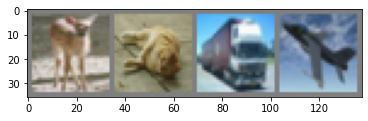

 deer   cat truck airplane


In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc(x)
        return x


net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
if exists(CNN_PATH):
    net.load_state_dict(torch.load(CNN_PATH))
else:

    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), CNN_PATH)

In [ ]:
dataiter = iter(testloader)

In [157]:
images, labels = dataiter.next()

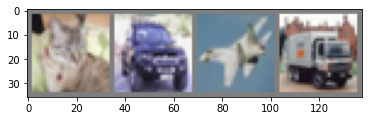

GroundTruth:    cat automobile airplane truck


In [158]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [13]:
print(f'Accuracy of the network on the test images: {(correct / total):3.2f} %%')

Accuracy of the network on the test images: 0.62 %%


In [14]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [15]:
list(net.modules())

[Net(
   (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=400, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc): Linear(in_features=84, out_features=10, bias=True)
 ),
 Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)),
 Linear(in_features=400, out_features=120, bias=True),
 Linear(in_features=120, out_features=84, bias=True),
 Linear(in_features=84, out_features=10, bias=True)]

In [19]:
target_layers = [list(net.modules())[2]]
input_tensor = images
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=net, target_layers=target_layers, use_cuda=False)

In [163]:
# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = labels
predicted_category = net(images).argmax(axis=1)
print('Predicted: ', ' '.join('%5s' % classes[predicted_category[j]] for j in range(4)))
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cams = cam(input_tensor=input_tensor, target_category=predicted_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cams[0,:]
print(target_category)
print(predicted_category)

Predicted:    cat truck airplane truck
tensor([3, 1, 0, 9])
tensor([3, 9, 0, 9])


In [164]:
visualization = show_cam_on_image(transpose(denorm(images[0,:]).numpy()), grayscale_cam, use_rgb=True)



In [165]:
viz = np.concatenate([show_cam_on_image(transpose(denorm(images[i,:]).numpy()), grayscale_cam, use_rgb=False)
               for i in range(grayscale_cams.shape[0])],
               axis=1)

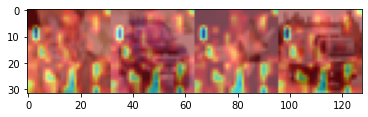

In [162]:
plt.imshow(viz)
plt.show()